In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh

sns.set(style="ticks", context="talk", palette="pastel")
plt.style.use('dark_background')

In [2]:
def generate_2d_normal(mean, sd=0.1, length=30):
    X0 = np.random.normal(loc = mean[0], scale = sd, size = length)
    X1 = np.random.normal(loc = mean[1], scale = sd, size = length)

    return np.vstack((X0, X1))

In [3]:
subset_1 = generate_2d_normal([-0.5, -0.2])
subset_2 = generate_2d_normal([0.0, 0.6])
subset_3 = generate_2d_normal([0.5, 0])

dataset = np.hstack((subset_1, subset_2, subset_3))

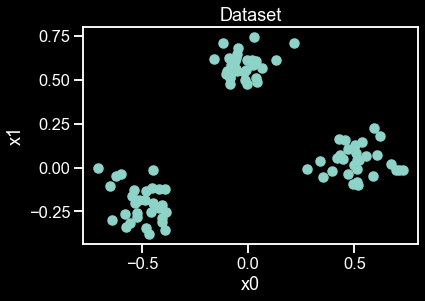

In [4]:
plt.scatter(dataset[0], dataset[1])
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Dataset')
plt.show()

In [5]:
def rbf(x, x_bar, sigma):
    return np.exp(- np.linalg.norm(x - x_bar)**2 / (2 * (sigma**2)))

In [6]:
def get_rbf_k(X,  sigma):
    p = X.shape[1]

    mat = np.zeros((p,p))

    for i in range(p):
        for j in range(p):
            mat[i, j] = rbf(X[:,i], X[:,j], sigma)
    
    #normalize
    
    row_mean = np.mean(mat, axis=0)
    col_mean = np.mean(mat, axis=1)
    mat_mean = np.mean(mat) 

    means = {'row':row_mean, 'col':col_mean, 'mat':mat_mean}

    for i in range(p):
        for j in range(p):
            mat[i, j] += mat_mean - row_mean[i] - col_mean[j]

    assert(np.abs(np.mean(mat)) <= 1e-12)
    return mat, means


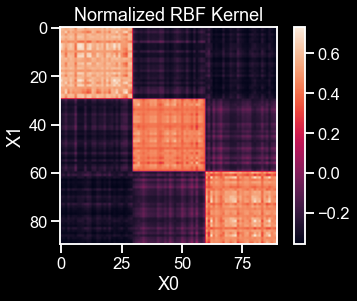

In [7]:
kernel, means = get_rbf_k(dataset, 0.5)
plt.title('Normalized RBF Kernel')
plt.xlabel('X0')
plt.ylabel('X1')
plt.imshow(kernel, aspect='equal')
plt.colorbar()
plt.show()

In [8]:
def eig_normalized(kernel):
    p = kernel.shape[0]

    e_val, e_vec = eigh(kernel)

    #val_sqrt = np.sqrt(e_val * p)
    #val_sqrt = np.sqrt(e_val)

    #norm_evec = e_vec/val_sqrt[:, None]
    #norm_evec /= np.linalg.norm(norm_evec, axis=0)[:, None] # normalized to unit vector

    order = np.argsort(-e_val)
    e_val_sorted = e_val[order]
    e_vec_sorted = norm_evec[:,order]


    return np.real(e_val_sorted), np.real(e_vec_sorted)
    #return e_val, norm_evec

In [9]:
def get_rbf_proj(X, ref_X, ref_means, sigma):
    p = X.shape[1]
    ref_p = ref_X.shape[1]
    mat = np.zeros((ref_p, p))

    for i in range(ref_p):
        for j in range(p):
            mat[i, j] = rbf(ref_X[:,i], X[:,j], sigma)
    
    #normalize
    
    row_mean = np.sum(mat, axis=0)/(ref_means['row'].shape[0])
    col_mean = ref_means['col']
    mat_mean = ref_means['mat']

    for i in range(ref_p):
        for j in range(p):
            mat[i, j] += mat_mean - row_mean[j] - col_mean[i]

    assert(np.abs(np.mean(mat)) <= 1e-12)
    return mat


In [10]:
pca_eval, pca_evec = eig_normalized(kernel)

<ipython-input-8-6d1be54444b4>:7: RuntimeWarning: invalid value encountered in sqrt
  val_sqrt = np.sqrt(e_val)


In [11]:
a = np.min(dataset[0])-0.1
b = np.max(dataset[0])+0.1

c = np.min(dataset[1])-0.1
d = np.max(dataset[1])+0.1

x0 = np.linspace(a, b, 20)
x1 = np.linspace(c, d, 20)

x00, x11 = np.meshgrid(x0, x1)
test_points = np.vstack((x00.ravel(), x11.ravel()))

In [12]:
testpoints_rbf = get_rbf_proj(test_points, dataset, means, 0.5)

In [18]:
evec_proj = pca_evec[:,:8] / np.sqrt(pca_eval[:8])
projected = evec_proj.T @ testpoints_rbf

C:\Users\brama\miniconda3\envs\py38\lib\site-packages\matplotlib\contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\brama\miniconda3\envs\py38\lib\site-packages\matplotlib\contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


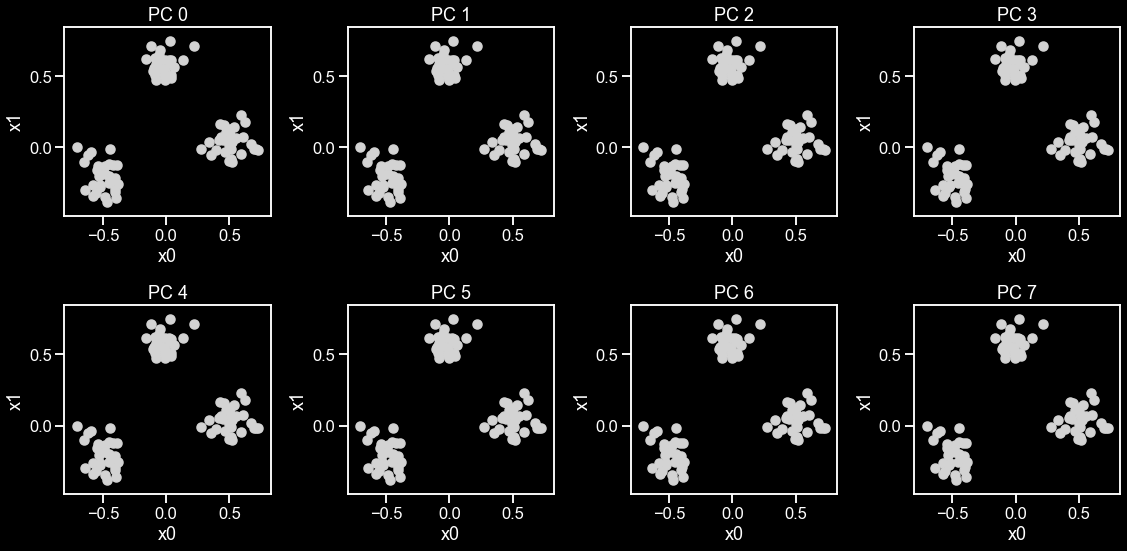

In [19]:
fig, ax = plt.subplots(2, 4, figsize = (16,8))

idx = 0
for i in range(2):
    for j in range(4):
        a = projected[idx,:].reshape((20,20))
        im = ax[i][j].contourf(x0, x1, a)
        ax[i][j].scatter(dataset[0], dataset[1], color='lightgray')
        ax[i][j].set_title('PC {}'.format(idx))
        ax[i][j].set_xlabel('x0')
        ax[i][j].set_ylabel('x1')
        idx += 1

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([1, 0, 0.05, 1])
#fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()